In [1]:
import numpy as np
np.random.seed(666)
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler

In [2]:
train_data = pd.read_csv("train.csv", index_col='Id')
print(train_data.shape)
train_data.head()

(1460, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
test_data = pd.read_csv("test.csv", index_col='Id')
sample = pd.read_csv("sample_submission.csv")

In [4]:
y = train_data['SalePrice']
train_data.drop(columns='SalePrice', inplace=True)

# EDA & Preprocessing

Посмотрим на статистику и гистограмму цена продажи

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

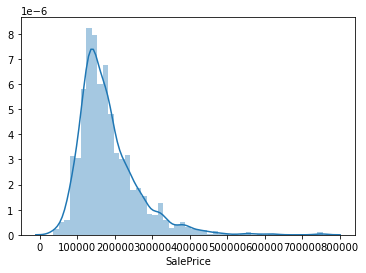

In [5]:
sns.distplot(y)
y.describe()

Распределение скошено, давайте пролограрифмируем, чтобы распределение стало более нормальным. updated: оказывается это советуется в самой задаче :)

In [6]:
y = np.log1p(y)

count    1460.000000
mean       12.024057
std         0.399449
min        10.460271
25%        11.775105
50%        12.001512
75%        12.273736
max        13.534474
Name: SalePrice, dtype: float64

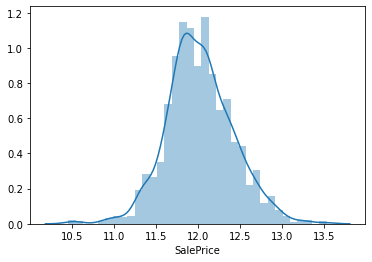

In [7]:
sns.distplot(y)
y.describe()

Хотя мы привели к более нормальному виду, но остались по краям выбросы. Уберем их из обучающей выборки

In [8]:
# max_quant = y.quantile(.75) + 1.5 * (y.quantile(.75) - y.quantile(.25))
# min_quant = y.quantile(.25) - 1.5 * (y.quantile(.75) - y.quantile(.25))

# train_data = train_data[(min_quant < y) & (y < max_quant)]
# y = y[(min_quant < y) & (y < max_quant)]

Создадим таблицу, которая показывает процент "пропущенности" каждой колонки.

In [9]:
nans = pd.DataFrame(
    {
        'Nans': train_data.isna().sum() / train_data.shape[0],
        'Dtype': train_data.dtypes,
    }
).sort_values('Nans', ascending=False)
nans.head(10)

,Nans,Dtype
PoolQC,0.995205,object
MiscFeature,0.963014,object
Alley,0.937671,object
Fence,0.807534,object
FireplaceQu,0.472603,object
LotFrontage,0.177397,float64
GarageType,0.055479,object
GarageYrBlt,0.055479,float64
GarageQual,0.055479,object
GarageCond,0.055479,object


 Уберем те колонки, в которых пропусков больше 0.06. В остальных заполним средним, если это числовая колонка или модой, если object

In [10]:
train_data.drop(columns=nans.loc[nans['Nans'] > 0.06].index, inplace=True)
test_data.drop(columns=nans.loc[nans['Nans'] > 0.06].index, inplace=True)

In [11]:
for column in train_data.columns:
    if train_data[column].dtype == np.dtype('object'):
        train_data[column] = train_data[column].fillna(train_data[column].mode().iloc[0])
    else:
        train_data[column] = train_data[column].fillna(train_data[column].mean())
    
    if test_data[column].dtype == np.dtype('object'):
        test_data[column] = test_data[column].fillna(test_data[column].mode().iloc[0])
    else:
        test_data[column] = test_data[column].fillna(test_data[column].mean())

Нарисуем хэтмап по корреляции

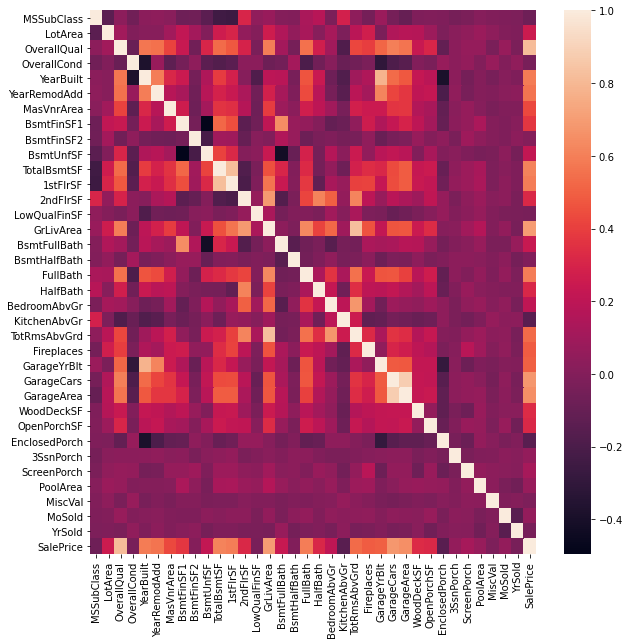

In [12]:
plt.figure(figsize=(10, 10))
for_corr = pd.concat((train_data, y), axis=1)
sns.heatmap(for_corr.corr());

Видно, что две пары: GarageCars - GarageArea, TotalBsmtSF - 1stFlrSF сильно коррелируют и надо убрать по одному из каждой пары, чтобы уменьшить мультиколленионароность между признаками

In [13]:
train_data.drop(columns=['GarageCars', 'TotalBsmtSF'], inplace=True)
test_data.drop(columns=['GarageCars', 'TotalBsmtSF'], inplace=True)

Разделим численные и строковые признаки

In [14]:
str_features = train_data.columns[train_data.dtypes == np.dtype('O')]
num_features = train_data.columns[train_data.dtypes != np.dtype('O')]

Все категориальные признаки обработаем с помощью One-hot-encoding

In [15]:
train_data = pd.get_dummies(train_data)
test_data  = pd.get_dummies(test_data)

Также на будущее составим список тех признаков, которые слабо коррелируют с целевым

In [16]:
weak_features = list(for_corr.corr()['SalePrice']
                     [for_corr.corr()['SalePrice'].abs() < 0.2].index)

Нормируем признаки, чтобы коэффициенты в линейной регрессии были в одном масштабе и потом можно даже регуляризаторы добавить

In [17]:
train = StandardScaler().fit_transform(train_data)
test  = StandardScaler().fit_transform(test_data)

train_data = pd.DataFrame(train, columns=train_data.columns, index=train_data.index)
test_data  = pd.DataFrame(test, columns=test_data.columns, index=test_data.index)

Уберем объекты, которые имеют выбросы по хотя бы по одному признаку

In [18]:
# train_data = train_data.loc[(np.abs(zscore(train_data[num_features])) < 3).all(axis=1)]

# fit predict 300k/sec

In [19]:
X = train_data[num_features]
test_X = test_data[num_features]
y = y.loc[train_data.index]

In [20]:
simple_model = LinearRegression()

In [21]:
def calculate_metric(model, X, y, show=True):
    scorers = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=5)
    scorers *= -1
    if show:
        print(f'mean: {scorers.mean():5f}; std: {scorers.std():5f}')
    return scorers.mean(), scorers.std()

In [22]:
calculate_metric(simple_model, X, y);

mean: 0.153615; std: 0.026417


# Lasso

Используем линейную регрессию с L1-Регуляризацией, чтобы отобрать признаки

Отберем лучшую alpha

In [23]:
alphas = np.logspace(-10, -1)

In [24]:
lasso_scorers = np.array([calculate_metric(Lasso(alpha=alpha), X, y, show=False) for alpha in alphas])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019085832776070788, tolerance: 0.018912592760396085
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.038338479441474504, tolerance: 0.018810611883705176
  positive)


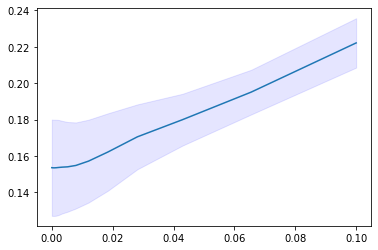

In [25]:
plt.fill_between(
    alphas,
    lasso_scorers[:, 0] - lasso_scorers[:, 1],
    lasso_scorers[:, 0] + lasso_scorers[:, 1],
    alpha=.1, color='b'
)
plt.plot(alphas, lasso_scorers[:, 0])
plt.show()

Самая нестрогая модель - самая лучшая

In [26]:
lasso = Lasso(alpha=alphas[lasso_scorers[:, 0].argmin()])

In [27]:
lasso.fit(X, y)

Lasso(alpha=0.0006250551925273976, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

Одна из особенностей Лассо - это возможность отбирать признаки, смотря на коэффициенты. Видно, что играют роль только 10 признаков

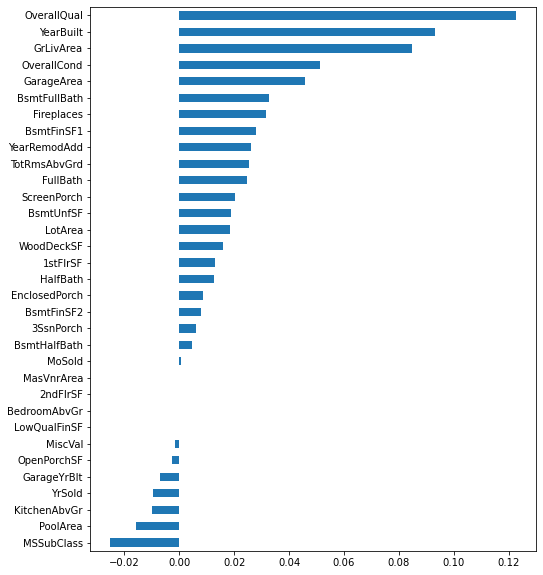

In [28]:
coefs = pd.Series(lasso.coef_, index=X.columns).sort_values(ascending=True)
coefs.plot(kind='barh', figsize=(8, 10));

In [29]:
columns = X.columns[~X.columns.isin(weak_features)]

In [30]:
# X = X[coefs[coefs.abs() > 0.01].index]
# test_X = test_X[coefs[coefs.abs() > 0.01].index]

In [31]:
calculate_metric(LinearRegression(), X, y);

mean: 0.153615; std: 0.026417


In [32]:
final_model = LinearRegression()
final_model.fit(X, y);

# tuning

Линейную регрессию никак не будем тюнить, так как никаких гиперпараметров не содержить

In [33]:
linear = LinearRegression()
linear.fit(X, y)
calculate_metric(linear, X, y);

mean: 0.153615; std: 0.026417


Для лассо уже можем подогнать альфу

In [34]:
params = {'alpha': np.logspace(-10, 1)}
gs = GridSearchCV(Lasso(max_iter=20000), params, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error')
gs.fit(X, y)

lasso = gs.best_estimator_
calculate_metric(lasso, X, y);

mean: 0.153499; std: 0.026418


Тоже самое для риджа

In [35]:
params = {'alpha': np.logspace(-10, 1)}
gs = GridSearchCV(Ridge(max_iter=50000), params, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error')
gs.fit(X, y)

ridge = gs.best_estimator_
calculate_metric(ridge, X, y);

mean: 0.153373; std: 0.026305


И SGD

In [36]:
params = {'alpha': np.logspace(-10, 1)}
gs = GridSearchCV(SGDRegressor(max_iter=50000), params, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error')
gs.fit(X, y)

sgd = gs.best_estimator_
calculate_metric(sgd, X, y);

mean: 0.153337; std: 0.025275


In [37]:
final_pred = []

# linear_pred = linear.predict(X)
# final_pred.append(linear_pred)
lasso_pred = lasso.predict(X)
final_pred.append(lasso_pred)
ridge_pred = ridge.predict(X)
final_pred.append(ridge_pred)
# sgd_pred = sgd.predict(X)
# final_pred.append(sgd_pred)

final_pred = np.mean(final_pred, axis=0)
print("mean: {:.5f}".format(np.sqrt(np.mean((final_pred - y)**2))))

mean: 0.14648


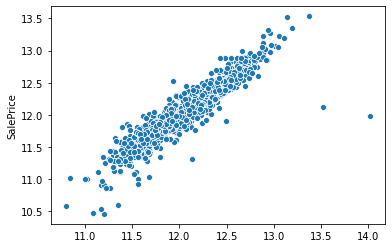

In [38]:
sns.scatterplot(final_pred, y)

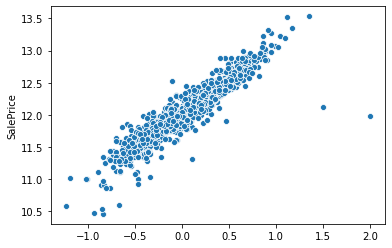

In [39]:
sns.scatterplot(np.sum(X * linear.coef_, axis=1), y)

In [40]:
X.iloc[:, 11].describe()

count    1.460000e+03
mean    -3.269835e-17
std      1.000343e+00
min     -7.951632e-01
25%     -7.951632e-01
50%     -7.951632e-01
75%      8.731117e-01
max      3.936963e+00
Name: 2ndFlrSF, dtype: float64

In [41]:
linear.coef_

array([-2.58610894e-02,  1.83542142e-02,  1.20659613e-01,  5.27004144e-02,
        9.58809385e-02,  2.59355580e-02, -7.46960616e-05,  3.18614561e-02,
        9.52830063e-03,  2.35276467e-02, -5.73111938e+11, -6.47148457e+11,
       -7.20831669e+10,  7.79018710e+11,  3.37897431e-02,  5.46211531e-03,
        2.66845848e-02,  1.36881312e-02, -2.95719782e-03, -1.06698603e-02,
        2.85053170e-02,  3.13630019e-02, -1.03049867e-02,  4.56763193e-02,
        1.63865288e-02, -3.96825049e-03,  1.01138057e-02,  6.45549189e-03,
        2.08739901e-02, -1.67590069e-02, -2.38585943e-03,  1.26600602e-03,
       -9.93676460e-03])

In [42]:
np.arange(len(final_pred))[final_pred > 13.1] # 1089, 1222

array([ 523,  691,  769, 1169, 1182, 1298])

In [43]:
final_pred = []

# linear_pred = linear.predict(test_X)
# final_pred.append(linear_pred)
lasso_pred = lasso.predict(test_X)
final_pred.append(lasso_pred)
ridge_pred = ridge.predict(test_X)
final_pred.append(ridge_pred)
# sgd_pred = sgd.predict(test_X)
# final_pred.append(sgd_pred)

final_pred = np.mean(final_pred, axis=0)

# Submit

In [44]:
preds = final_pred
sample['SalePrice'] = np.expm1(preds)
sample.to_csv('submission.csv', index=False)

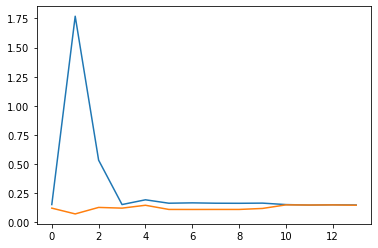

In [45]:
kaggle = [0.15211, 1.76931, 0.53342, 0.15211, 0.19300, 0.16361, 0.16674, 0.16361, 0.16299, 0.16440, 0.15198, 0.14761, 0.15032, 0.14842]
my = [0.121395, 0.071753, 0.127545, 0.121395, 0.146055, 0.110177, 0.109947, 0.110177, 0.110162, 0.118771, 0.14931, 0.14810, 0.14902, 0.14648]
plt.plot(kaggle)
plt.plot(my)
plt.show()